In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

In [2]:
train_set = torchvision.datasets.MNIST('mnist_data', train=True, 
                                       transform=transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST('mnist_data', train=False,     
                                       transform=transforms.ToTensor(), download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 236759686.59it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 75852031.20it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 59175933.91it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12854607.81it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [3]:
train_loader = DataLoader(dataset=train_set, batch_size=1024, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=1024, shuffle=True)

In [55]:
class MNIST(nn.Module):
    def __init__(self, input_size=28*28, out_size=10):
        super(MNIST, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 150)
        self.fc3 = nn.Linear(150, 100)
        self.fc4 = nn.Linear(100, out_size)
        
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.relu(self.fc1(x)) 
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        
        return out

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
lr = 1e-1
model = MNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [70]:
import time
n_epochs = 30

val_accs_sgd, val_losses_sgd = [], []
start = time.time()
for epoch in range(n_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        losses = []
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            losses.append(loss)

            _, prediction=torch.max(output, 1)
            n_samples += labels.shape[0]
            n_correct += (prediction==labels).sum().item()
            
        
        accuracy=(n_correct / n_samples) * 100
        print('Train:', accuracy, torch.mean(torch.tensor(losses)))
        
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        losses = []
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            losses.append(loss)

            _, prediction=torch.max(output, 1)
            n_samples += labels.shape[0]
            n_correct += (prediction==labels).sum().item()
            
        
        accuracy=(n_correct / n_samples) * 100
        print('Val:', accuracy, torch.mean(torch.tensor(losses)))
        val_accs_sgd.append(accuracy)
        val_losses_sgd.append(torch.mean(torch.tensor(losses)))

print(time.time() - start)

0
Train: 43.138333333333335 tensor(2.2362)
Val: 42.980000000000004 tensor(2.2346)
1
Train: 61.70666666666666 tensor(1.2684)
Val: 62.7 tensor(1.2548)
2
Train: 78.75999999999999 tensor(0.7013)
Val: 79.51 tensor(0.6801)
3
Train: 83.53833333333334 tensor(0.5206)
Val: 83.83 tensor(0.5097)
4
Train: 86.545 tensor(0.4548)
Val: 86.82 tensor(0.4407)
5
Train: 89.08833333333334 tensor(0.3769)
Val: 89.38000000000001 tensor(0.3642)
6
Train: 90.05333333333333 tensor(0.3431)
Val: 90.02 tensor(0.3324)
7
Train: 90.70166666666667 tensor(0.3217)
Val: 90.53999999999999 tensor(0.3149)
8
Train: 91.46 tensor(0.2988)
Val: 91.52 tensor(0.2955)
9
Train: 91.94833333333334 tensor(0.2786)
Val: 91.61 tensor(0.2773)
10
Train: 92.47666666666666 tensor(0.2626)
Val: 92.34 tensor(0.2581)
11
Train: 92.95 tensor(0.2423)
Val: 92.95 tensor(0.2411)
12
Train: 92.73 tensor(0.2461)
Val: 92.54 tensor(0.2457)
13
Train: 93.69666666666666 tensor(0.2184)
Val: 93.45 tensor(0.2185)
14
Train: 93.61500000000001 tensor(0.2192)
Val: 93.61 

In [15]:
import numpy as np

def t_bounds(p, d, a):
    '''
    Find minimum and maximum t, so optimized area is inside rectangle
    :param p: np.array, point
    :param d: np.array, vector
    :param a: float, bound
    :return: (float, float), min and max t
    '''
    p = p.flatten()
    d = d.flatten()
    dim = p.shape[0]
   
    pos_t, neg_t = torch.inf, -torch.inf
    pos_t2, neg_t2 = torch.inf, -torch.inf
    t_tmp = (a - p) / d
    t_tmp_pos = t_tmp[t_tmp >= 0]
    t_tmp_neg = t_tmp[t_tmp < 0]
    if len(t_tmp_pos) > 0:
        pos_t = t_tmp[t_tmp >= 0].min()
    if len(t_tmp_neg) > 0:
        neg_t = t_tmp[t_tmp < 0].max()
    
    t_tmp = (-a - p) / d
    t_tmp_pos = t_tmp[t_tmp >= 0]
    t_tmp_neg = t_tmp[t_tmp < 0]
    if len(t_tmp_pos) > 0:
        pos_t2 = t_tmp[t_tmp >= 0].min()
    if len(t_tmp_neg) > 0:
        neg_t2 = t_tmp[t_tmp < 0].max()
        
    pos_t = torch.min(torch.tensor(pos_t), torch.tensor(pos_t2))
    neg_t = torch.max(torch.tensor(neg_t), torch.tensor(neg_t2))

    return (neg_t, pos_t)


class GlobalGradientOptimizer(optim.Optimizer):
    
    def __init__(self, params, lr=1e-3, bound=1):
        super(GlobalGradientOptimizer, self).__init__(params, defaults={'lr': lr})
        self.state = dict()
        self.bound = bound
        
    def step(self, closure):
        for group in self.param_groups:
            for p in group['params']:
                min_f = closure()
                
                grad = p.grad.data
                point = p.data
                d = grad
                point = torch.clip(point, -self.bound, self.bound)
                lb, rb = t_bounds(point, d, self.bound)
                
                step = group['lr'] * (rb - lb)
                t_arr = torch.arange(lb, rb, step)
                min_t = 0

                for t in t_arr:
                    p.data = point + t * grad
                    current_f = closure()
                    if current_f < min_f:
                        min_t = t
                        min_f = current_f
                        
                p.data = point + min_t * grad


class RandomVectorOptimizer(optim.Optimizer):
    
    def __init__(self, params, lr=1e-3, bound=1, num_vectors=10):
        super(RandomVectorOptimizer, self).__init__(params, defaults={'lr': lr})
        self.state = dict()
        self.bound = bound
        self.num_vectors = num_vectors
        
    def step(self, closure):
        for group in self.param_groups:
            for p in group['params']:
                start_p = p.data
                
                min_t = 0
                min_f = closure()
                best_grad = torch.zeros(p.grad.shape).to(device)
                for i in range(self.num_vectors):
                    min_f = closure()

                    grad = (torch.rand(p.grad.shape) * 2 - 1).to(device)
                    point = p.data
                    d = grad
                    d2 = p.grad.data

                    point = torch.clip(point, -self.bound, self.bound)
                    lb, rb = t_bounds(point, d, self.bound)
                    #lb, rb = -100, 100

                    step = group['lr'] * (rb - lb)
                    t_arr = torch.arange(lb, rb, step)
                    min_t = 0

                    for t in t_arr:
                        p.data = point + t * grad
                        current_f = closure()
                        if current_f < min_f:
                            min_t = t
                            min_f = current_f
                            best_grad = grad

                p.data = start_p + min_t * best_grad

In [65]:
lr = 1e-1 / 4
model = MNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = GlobalGradientOptimizer(model.parameters(), bound=1, lr=lr)
#optimizer = GlobalGradientOptimizer(model.parameters(), bound=1, lr=lr)
#optimizer = RandomVectorOptimizer(model.parameters(), lr=lr)

n_epochs = 30

val_accs = []
val_losses = []
start = time.time()
for epoch in range(n_epochs):
    print(epoch)
    n_correct = 0
    n_samples = 0
    
    for i, (images, labels) in enumerate(train_loader):
        #print(i)
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        
        def closure():
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        losses = []
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            losses.append(loss)

            _, prediction=torch.max(output, 1)
            n_samples += labels.shape[0]
            n_correct += (prediction==labels).sum().item()
            
        
        accuracy=(n_correct / n_samples) * 100
        print('Train:', accuracy, torch.mean(torch.tensor(losses)))
        
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        losses = []
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            losses.append(loss)

            _, prediction=torch.max(output, 1)
            n_samples += labels.shape[0]
            n_correct += (prediction==labels).sum().item()
            
        
        accuracy=(n_correct / n_samples) * 100
        print('Val:', accuracy, torch.mean(torch.tensor(losses)))
        val_accs.append(accuracy)
        val_losses.append(torch.mean(torch.tensor(losses)))

print(time.time() - start)

0


/tmp/ipykernel_31/687152550.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_t = torch.min(torch.tensor(pos_t), torch.tensor(pos_t2))
/tmp/ipykernel_31/687152550.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_t = torch.max(torch.tensor(neg_t), torch.tensor(neg_t2))


Train: 86.84166666666667 tensor(0.4999)
Val: 87.14 tensor(0.4832)
1
Train: 87.13333333333333 tensor(0.4756)
Val: 87.49 tensor(0.4579)
2
Train: 87.275 tensor(0.4711)
Val: 87.64 tensor(0.4517)
3
Train: 87.48166666666667 tensor(0.4468)
Val: 87.82 tensor(0.4319)
4
Train: 87.795 tensor(0.4401)
Val: 88.2 tensor(0.4235)
5
Train: 88.11166666666666 tensor(0.4270)
Val: 88.46000000000001 tensor(0.4082)
6
Train: 88.56166666666667 tensor(0.4122)
Val: 88.97 tensor(0.3978)
7
Train: 88.58500000000001 tensor(0.4042)
Val: 89.0 tensor(0.3900)
8
Train: 88.675 tensor(0.4013)
Val: 88.92999999999999 tensor(0.3855)
9
Train: 88.765 tensor(0.3959)
Val: 89.09 tensor(0.3804)
10
Train: 88.82666666666667 tensor(0.3933)
Val: 89.05 tensor(0.3779)
11
Train: 88.85 tensor(0.3905)
Val: 89.25 tensor(0.3759)
12
Train: 89.09 tensor(0.3837)
Val: 89.41 tensor(0.3683)
13
Train: 89.06833333333334 tensor(0.3818)
Val: 89.44 tensor(0.3665)
14
Train: 89.33166666666666 tensor(0.3721)
Val: 89.68 tensor(0.3560)
15
Train: 89.4466666666

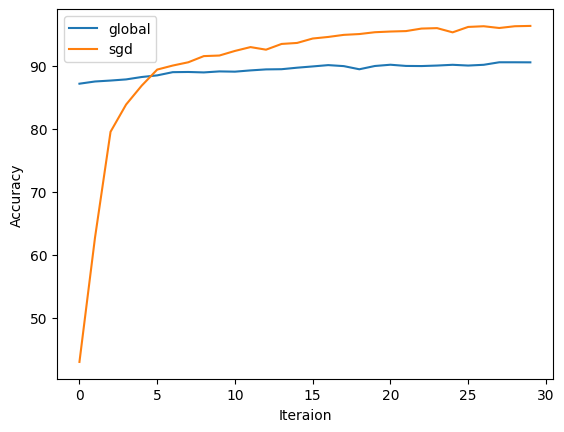

In [78]:
plt.plot(val_accs, label='global')
plt.plot(val_accs_sgd, label='sgd')
plt.xlabel('Iteraion')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [72]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(1, 16, 5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.out = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [13]:
n_epochs = 10
lr = 0.1

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

accs_cnn_sgd, losses_cnn_sgd = [], []
start = time.time()
for epoch in range(n_epochs):
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        losses = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            losses.append(loss)

            _, prediction=torch.max(output, 1)
            n_samples += labels.shape[0]
            n_correct += (prediction==labels).sum().item()
            
        
        accuracy=(n_correct / n_samples) * 100
        print('Train:', accuracy, torch.mean(torch.tensor(losses)))
        
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        losses = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            losses.append(loss)

            _, prediction=torch.max(output, 1)
            n_samples += labels.shape[0]
            n_correct += (prediction==labels).sum().item()
            
        
        accuracy=(n_correct / n_samples) * 100
        print('Val:', accuracy, torch.mean(torch.tensor(losses)))
        accs_cnn_sgd.append(accuracy)
        losses_cnn_sgd.append(torch.mean(torch.tensor(losses)))

print(time.time() - start)

0
Train: 78.15333333333334 tensor(0.6187)
Val: 79.09 tensor(0.5930)
1
Train: 92.16666666666666 tensor(0.2712)
Val: 92.80000000000001 tensor(0.2547)
2
Train: 94.135 tensor(0.2016)
Val: 94.62 tensor(0.1863)
3
Train: 95.325 tensor(0.1630)
Val: 95.59 tensor(0.1504)
4
Train: 95.73333333333333 tensor(0.1464)
Val: 95.98 tensor(0.1346)
5
Train: 96.465 tensor(0.1242)
Val: 96.67 tensor(0.1142)
6
Train: 96.69 tensor(0.1145)
Val: 96.87 tensor(0.1060)
7
Train: 96.87333333333333 tensor(0.1039)
Val: 97.14 tensor(0.0936)
8
Train: 97.08666666666666 tensor(0.0983)
Val: 97.06 tensor(0.0877)
9
Train: 97.38 tensor(0.0898)
Val: 97.48 tensor(0.0799)
139.22251629829407


In [16]:
lr = 1e-1 / 4
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = GlobalGradientOptimizer(model.parameters(), lr=lr, bound=0.6)

n_epochs = 10

accs_cnn, losses_cnn = [], []
start = time.time()
for epoch in range(n_epochs):
    print(epoch)
    n_correct = 0
    n_samples = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        def closure():
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        losses = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            losses.append(loss)

            _, prediction=torch.max(output, 1)
            n_samples += labels.shape[0]
            n_correct += (prediction==labels).sum().item()
            
        
        accuracy=(n_correct / n_samples) * 100
        print('Train:', accuracy, torch.mean(torch.tensor(losses)))
        
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        losses = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            losses.append(loss)

            _, prediction=torch.max(output, 1)
            n_samples += labels.shape[0]
            n_correct += (prediction==labels).sum().item()
            
        
        accuracy=(n_correct / n_samples) * 100
        print('Val:', accuracy, torch.mean(torch.tensor(losses)))
        accs_cnn.append(accuracy)
        losses_cnn.append(torch.mean(torch.tensor(losses)))

print(time.time() - start)

0


/tmp/ipykernel_31/687152550.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_t = torch.min(torch.tensor(pos_t), torch.tensor(pos_t2))
/tmp/ipykernel_31/687152550.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_t = torch.max(torch.tensor(neg_t), torch.tensor(neg_t2))


Train: 79.62833333333333 tensor(0.6748)
Val: 79.99000000000001 tensor(0.6563)
1
Train: 83.62666666666667 tensor(0.5624)
Val: 84.0 tensor(0.5459)
2
Train: 84.32166666666666 tensor(0.5304)
Val: 84.81 tensor(0.5129)
3
Train: 85.46000000000001 tensor(0.4963)
Val: 86.08 tensor(0.4806)
4
Train: 86.085 tensor(0.4747)
Val: 86.56 tensor(0.4609)
5
Train: 86.66833333333334 tensor(0.4600)
Val: 87.21 tensor(0.4435)
6
Train: 87.12333333333333 tensor(0.4449)
Val: 87.6 tensor(0.4307)
7
Train: 86.93666666666667 tensor(0.4433)
Val: 87.47 tensor(0.4289)
8
Train: 88.12333333333333 tensor(0.4153)
Val: 88.62 tensor(0.4000)
9
Train: 88.24 tensor(0.4061)
Val: 88.68 tensor(0.3916)
1031.0057249069214


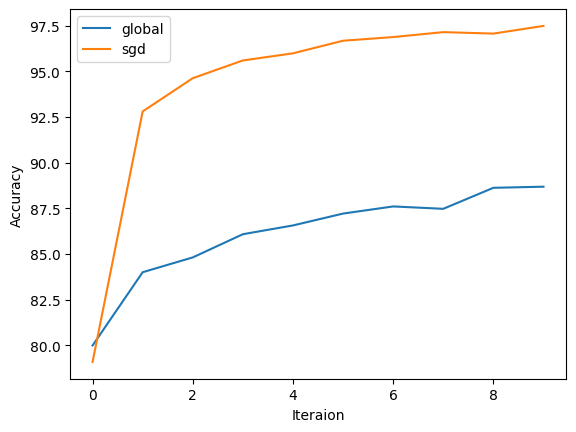

In [17]:
plt.plot(accs_cnn, label='global')
plt.plot(accs_cnn_sgd, label='sgd')
plt.xlabel('Iteraion')
plt.ylabel('Accuracy')
plt.legend()

plt.show()